# Imports

In [2]:
import utils, models_preprocessing, metrics
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import PIL.Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy import stats, integrate
import seaborn as sns
sns.set(color_codes=True)

from keras import models
from keras.models import save_model, load_model
from keras.preprocessing import image
from quiver_engine import server

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Read CSV

In [3]:
parameters = pd.read_csv('classifications.csv', low_memory=False)

In [4]:
parameters.head()

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,6.040000e-10,804,3714.6800
1,100001,0,4.700000e-11,0,0.0000
2,100002,1,7.180000e-11,51,57.6093
3,100003,1,1.760000e-11,347,18815.4000
4,100004,0,2.030000e-09,0,0.0000


# Train model

In [5]:
data = np.load('data/imadjust.npy')
labels = np.load('labels/classification.npy')

In [6]:
model_function = models_preprocessing.compiledConvnet
auroc = metrics.auroc
accuracy = metrics.accuracy
text = metrics.basicTextMetrics

In [7]:
%matplotlib inline

In [8]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, labels, test_size=0.2, shuffle=False)

In [9]:
model = utils.train(model_function(), 20, Xtrain, Ytrain)

Epoch 1/20
16000/16000 [==============================] - 114s 7ms/step - loss: 0.5491 - acc: 0.7305
Epoch 2/20
16000/16000 [==============================] - 114s 7ms/step - loss: 0.4349 - acc: 0.8041
Epoch 3/20
16000/16000 [==============================] - 113s 7ms/step - loss: 0.3777 - acc: 0.8367
Epoch 4/20
16000/16000 [==============================] - 113s 7ms/step - loss: 0.3351 - acc: 0.8559
Epoch 5/20
16000/16000 [==============================] - 113s 7ms/step - loss: 0.3025 - acc: 0.8734
Epoch 6/20
16000/16000 [==============================] - 113s 7ms/step - loss: 0.2738 - acc: 0.8870
Epoch 7/20
16000/16000 [==============================] - 113s 7ms/step - loss: 0.2454 - acc: 0.8988
Epoch 8/20
16000/16000 [==============================] - 113s 7ms/step - loss: 0.2200 - acc: 0.9139
Epoch 9/20
16000/16000 [==============================] - 114s 7ms/step - loss: 0.1993 - acc: 0.9208
Epoch 10/20
16000/16000 [==============================] - 113s 7ms/step - loss: 0.1784 - a

In [9]:
os.makedirs('models', exist_ok=True)
PATH = 'models/'

In [11]:
save_model(model, f'{PATH}model_cConv.hdf5')

In [10]:
model = load_model(f'{PATH}model_cConv.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 64)        2368      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1936)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               247936    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
__________

# Predictions

In [11]:
preds_test = model.predict_classes(Xtest)
probs_test = model.predict(Xtest)

In [12]:
preds_data = model.predict_classes(data)
probs_data = model.predict(data)

In [13]:
model.evaluate(Xtest, Ytest)

4000/4000 [==============================] - 13s 3ms/step


[0.55888201680779459, 0.85050000000000003]

In [14]:
preds_test

array([[1],
       [0],
       [0],
       ..., 
       [0],
       [0],
       [0]], dtype=int32)

# EDA

## Test parameters

In [15]:
parameters.head()

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,6.040000e-10,804,3714.6800
1,100001,0,4.700000e-11,0,0.0000
2,100002,1,7.180000e-11,51,57.6093
3,100003,1,1.760000e-11,347,18815.4000
4,100004,0,2.030000e-09,0,0.0000


In [16]:
test_params = pd.read_csv('classifications.csv', skiprows=range(1, 16001))

In [17]:
test_params.insert(2, 'is_lens_preds', preds_test)

In [18]:
test_params.head()

,ID,is_lens,is_lens_preds,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,116000,0,1,1.720000e-09,0,0.000
1,116001,1,0,8.610000e-12,69,132.736
2,116002,0,0,1.390000e-10,0,0.000
3,116003,1,1,7.060000e-12,120,227.222
4,116004,1,1,1.890000e-09,104,278.564


In [19]:
Einstein_radius = np.sqrt(test_params.Einstein_area / (np.pi))

In [20]:
test_params['Einstein_radius'] = Einstein_radius

In [21]:
test_params.head()

,ID,is_lens,is_lens_preds,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma,Einstein_radius
0,116000,0,1,1.720000e-09,0,0.000,0.000023
1,116001,1,0,8.610000e-12,69,132.736,0.000002
2,116002,0,0,1.390000e-10,0,0.000,0.000007
3,116003,1,1,7.060000e-12,120,227.222,0.000001
4,116004,1,1,1.890000e-09,104,278.564,0.000025


In [22]:
test_params.insert(3, 'probs', probs_test)

In [23]:
test_params.head()

,ID,is_lens,is_lens_preds,probs,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma,Einstein_radius
0,116000,0,1,0.999989,1.720000e-09,0,0.000,0.000023
1,116001,1,0,0.101402,8.610000e-12,69,132.736,0.000002
2,116002,0,0,0.000594,1.390000e-10,0,0.000,0.000007
3,116003,1,1,0.999986,7.060000e-12,120,227.222,0.000001
4,116004,1,1,0.999812,1.890000e-09,104,278.564,0.000025


## Negatives and Positives

In [24]:
negatives = test_params[test_params.is_lens == 0]; positives = test_params[test_params.is_lens == 1]

In [25]:
negatives.head()

,ID,is_lens,is_lens_preds,probs,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma,Einstein_radius
0,116000,0,1,0.999989,1.720000e-09,0,0.0,0.000023
2,116002,0,0,0.000594,1.390000e-10,0,0.0,0.000007
6,116006,0,0,0.002157,1.430000e-11,0,0.0,0.000002
7,116007,0,0,0.008905,1.020000e-10,0,0.0,0.000006
9,116009,0,1,0.911055,1.140000e-10,0,0.0,0.000006


In [26]:
positives.head()

,ID,is_lens,is_lens_preds,probs,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma,Einstein_radius
1,116001,1,0,0.101402,8.610000e-12,69,132.7360,0.000002
3,116003,1,1,0.999986,7.060000e-12,120,227.2220,0.000001
4,116004,1,1,0.999812,1.890000e-09,104,278.5640,0.000025
5,116005,1,0,0.194538,1.740000e-09,20,26.3226,0.000024
8,116008,1,1,0.999971,7.960000e-11,160,249.5430,0.000005


# Plots

## Einstein radius 

### Histogram

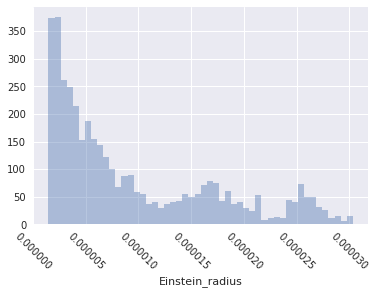

In [27]:
sns.distplot(test_params.Einstein_radius, kde=False, bins=50)
plt.xticks(rotation=-45);

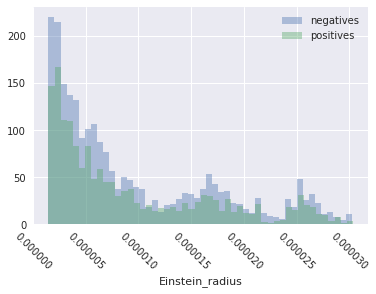

In [28]:
sns.distplot(negatives.Einstein_radius, kde=False, bins=50)
sns.distplot(positives.Einstein_radius, kde=False, bins=50)
plt.legend(['negatives', 'positives'])
plt.xticks(rotation=-45);

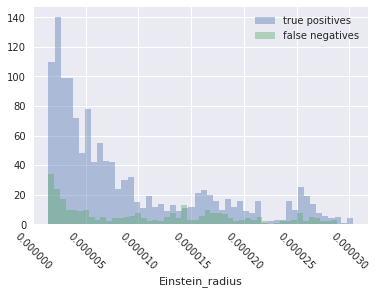

In [29]:
sns.distplot(positives.Einstein_radius[positives.is_lens_preds==1], kde=False, bins=50)
sns.distplot(positives.Einstein_radius[positives.is_lens_preds==0], kde=False, bins=50)
plt.legend(['true positives', 'false negatives'])
plt.xticks(rotation=-45);

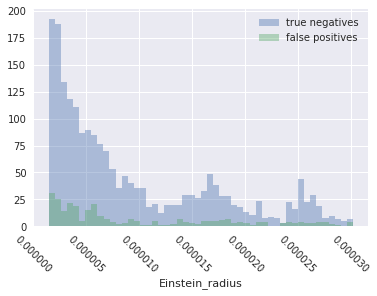

In [30]:
sns.distplot(negatives.Einstein_radius[negatives.is_lens_preds==0], kde=False, bins=50)
sns.distplot(negatives.Einstein_radius[negatives.is_lens_preds==1], kde=False, bins=50)
plt.legend(['true negatives', 'false positives'])
plt.xticks(rotation=-45);

### Stripplot

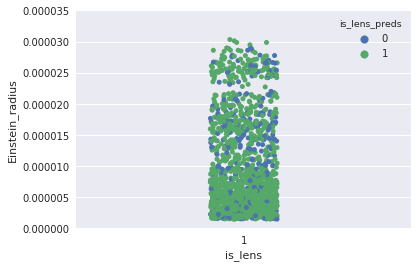

In [31]:
sns.stripplot(x="is_lens", y="Einstein_radius", data=positives, jitter=True, hue='is_lens_preds')
plt.ylim([0.00000005, 0.000035]);

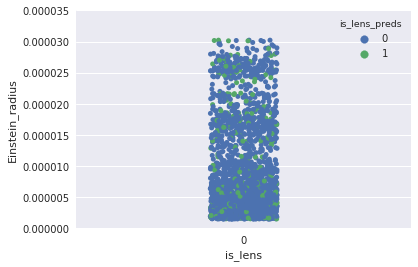

In [32]:
sns.stripplot(x="is_lens", y="Einstein_radius", data=negatives, jitter=True, hue='is_lens_preds')
plt.ylim([0.00000005, 0.000035]);

### Violinplot

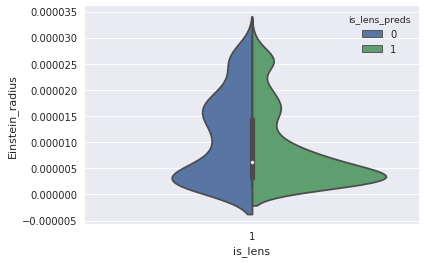

In [33]:
sns.violinplot(x="is_lens", y="Einstein_radius", data=positives, hue='is_lens_preds', split=True);

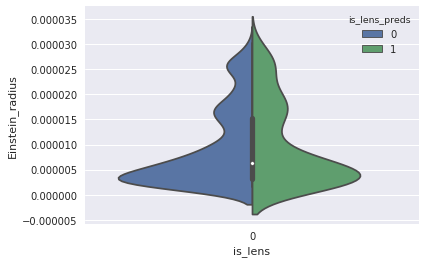

In [34]:
sns.violinplot(x="is_lens", y="Einstein_radius", data=negatives, hue='is_lens_preds', split=True);

### Factorplot

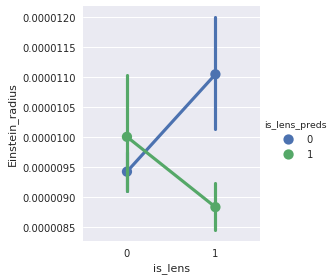

In [35]:
sns.factorplot(x="is_lens", y="Einstein_radius", data=test_params, hue='is_lens_preds');

## Strong Lenses

### Scatter plots

In [36]:
sns.set()

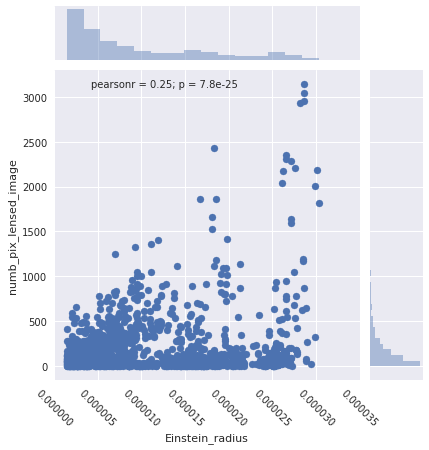

In [37]:
g = sns.jointplot(x='Einstein_radius', y='numb_pix_lensed_image', data=positives, 
                  xlim=(0.00000005, 0.000035))
g.ax_joint.set_xticklabels(g.ax_joint.get_xticklabels(), rotation = -45);

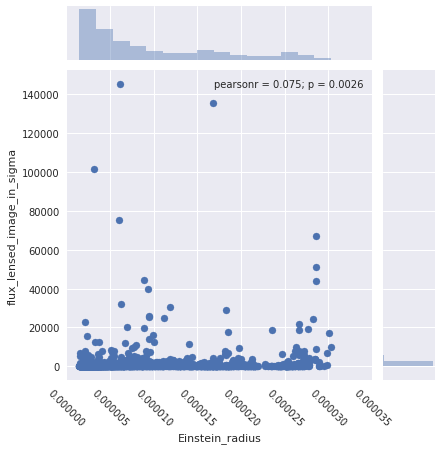

In [38]:
f = sns.jointplot(x='Einstein_radius', y='flux_lensed_image_in_sigma', data=positives, 
              xlim=(0.00000005, 0.000035))
f.ax_joint.set_xticklabels(f.ax_joint.get_xticklabels(), rotation = -45);

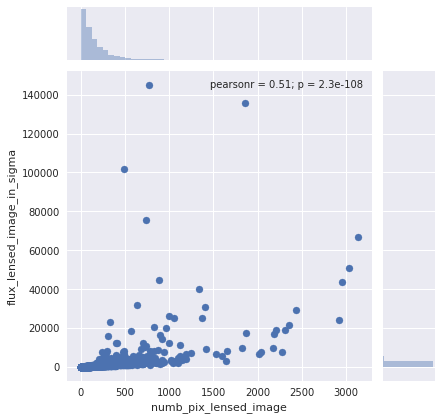

In [39]:
h = sns.jointplot(x='numb_pix_lensed_image', y='flux_lensed_image_in_sigma', data=positives);

### Exploring lmplot

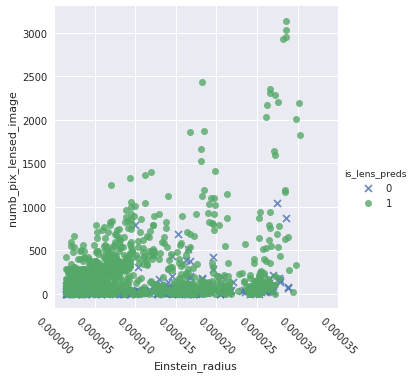

In [50]:
sns.lmplot(x='Einstein_radius', y='numb_pix_lensed_image', data=positives, fit_reg=False, 
           hue='is_lens_preds', markers=["x", "o"])
plt.xlim([0.00000005, 0.000035])
plt.xticks(rotation=-45);

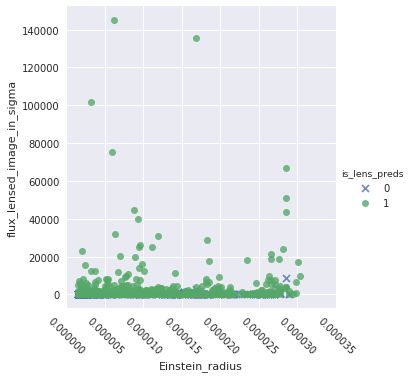

In [51]:
sns.lmplot(x='Einstein_radius', y='flux_lensed_image_in_sigma', data=positives, fit_reg=False, 
           hue='is_lens_preds', markers=["x", "o"])
plt.xlim([0.00000005, 0.000035])
plt.xticks(rotation=-45);

## More plots